# Objective
* 20191002: 
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Using xgboost
* 20191004 - Diff from StockPricePrediction_v6_xgboost.ipynb:
    * Instead of using mean and std from train set to do scaling/unscaling, use mean and std from the last N days to do scaling/unscaling
* 20191007 - Diff from StockPricePrediction_v6a_xgboost.ipynb:
    * Include a validation set to do hyperparameter tuning
* 20191018 - Diff from StockPricePrediction_v6b_xgboost.ipynb:
    * Instead of tuning N, we use a fixed N and observe the results
* 20191021 - Diff from StockPricePrediction_v6c_xgboost.ipynb:
    * Instead of using only features about price, introduce more features and observe the results

In [1255]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objs as go
import time

from collections import defaultdict
from datetime import date
from fastai.tabular import add_datepart
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

# py.sign_in('<your-user-id>', '<your-api-key>') # sign in to plotly if you haven't done so

#### Input params ##################
folder = "./data/"
filename = "VTI_20130102_20181231.csv"

# Predicting on day 1008, date 2017-01-03 00:00:00
# Predicting on day 1050, date 2017-03-06 00:00:00
# Predicting on day 1092, date 2017-05-04 00:00:00
# Predicting on day 1134, date 2017-07-05 00:00:00
# Predicting on day 1176, date 2017-09-01 00:00:00
# Predicting on day 1218, date 2017-11-01 00:00:00
# Predicting on day 1260, date 2018-01-03 00:00:00
# Predicting on day 1302, date 2018-03-06 00:00:00
# Predicting on day 1344, date 2018-05-04 00:00:00
# Predicting on day 1386, date 2018-07-05 00:00:00
# Predicting on day 1428, date 2018-09-04 00:00:00
# Predicting on day 1470, date 2018-11-01 00:00:00

pred_day = 1470                # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                 # Use 1 year of data as validation set
N = 10                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [1256]:
tic1 = time.time()

# Common functions

In [1257]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [1258]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def pred_xgboost(model, X_test_ex_adj_close, series, N, H):
    """
    Do recursive forecasting using xgboost
    Inputs
        model : the xgboost model
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        series: numpy array of shape (len(series),). The time series we want to do recursive forecasting on
        N     : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H     : forecast horizon
    Outputs
        Times series of predictions. Numpy array of shape (H,).
    """
    forecast = series.copy()

    for n in range(H):
        # Create the features dataframe
        X = X_test_ex_adj_close[n:n+1].copy()
        for n in range(N,0,-1):
            X.loc[:, "adj_close_scaled_lag_"+str(n)] = forecast[-n]
        
        # Do prediction
        est = model.predict(X)
        
        # Append prediction to forecast series
        forecast = np.append(forecast, est)

    return forecast[-H:]

def unscale_test_est(scaled, prev_vals, prev_mean_val, prev_std_val):
    """
    Given a scaled series, unscale it
    Inputs
        scaled         : numpy array. The scaled series
        prev_vals      : numpy array. If scaled[0] is at time t, prev_vals will contain the N-1 unscaled values at t-1, t-2, ...
        prev_mean_val  : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val   : the std deviation of the unscaled values at t-1, t-2, ..., t-N
    Outputs
        unscaled values of same length as scaled
    """
    unscaled = np.concatenate([prev_vals, np.array((scaled[0] * prev_std_val) + prev_mean_val).reshape(1,)])
    N = prev_vals.shape[0] + 1
    
    for i in range(1, len(scaled)):
        mean_val = np.mean(unscaled[-N:])
        std_val = np.std(unscaled[-N:])
        unscaled = np.concatenate([unscaled, np.array(scaled[i] * std_val + mean_val).reshape(1,)])
        
    return np.array(unscaled[prev_vals.shape[0]:])

def train_pred_eval_model(X_train_scaled,
                          y_train_scaled,
                          X_test_ex_adj_close,
                          y_test,
                          N,
                          H,
                          prev_vals,
                          prev_mean_val,
                          prev_std_val,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        y_test             : target for test. Actual values, not scaled.
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If scaled[0] is at time t, prev_vals will contain the N-1 unscaled values at t-1, t-2, ...
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = pred_xgboost(model, X_test_ex_adj_close, y_train_scaled.to_numpy(), N, H)

    # Do unscaling
    est = unscale_test_est(est_scaled, 
                           prev_vals, 
                           prev_mean_val, 
                           prev_std_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mape, mae, est, model.feature_importances_

def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_scaled_lag_1', 'adj_close_scaled_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df['order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
#     lag_cols = ['adj_close_scaled'] # List of columns that we will use to create lags
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df

def get_error_metrics(df,
                      train_size,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df.loc[:, 'adj_close_scaled'] = (df['adj_close'] - df['adj_close_mean']) / df['adj_close_std']
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close_scaled'])
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    for i in range(train_size, len(df)-H+1, int(H/2)):
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
    
        # Split into X and y
        X_train_scaled = train[features]
        y_train_scaled = train['adj_close_scaled']
        X_test_ex_adj_close = test[features_ex_adj_close]
        y_test = test['adj_close']
            
        rmse, mape, mae, est, _ = train_pred_eval_model(X_train_scaled,
                                                        y_train_scaled,
                                                        X_test_ex_adj_close,
                                                        y_test,
                                                        N,
                                                        H,
                                                        train[-N+1:]['adj_close'].to_numpy(),
                                                        test.iloc[0]['adj_close_mean'],
                                                        test.iloc[0]['adj_close_std'],
                                                        seed=seed,
                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight,
                                                        subsample=subsample,
                                                        colsample_bytree=colsample_bytree,
                                                        colsample_bylevel=colsample_bylevel,
                                                        gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict 

def get_error_metrics_one_pred(df,
                               train_size,
                               N,
                               H,
                               seed=100,
                               n_estimators=100,
                               max_depth=3,
                               learning_rate=0.1,
                               min_child_weight=1,
                               subsample=1,
                               colsample_bytree=1,
                               colsample_bylevel=1,
                               gamma=0):
    """
    Given a series consisting of both train+test, do one prediction of forecast horizon H on the test set.
    Inputs
        df                 : train + test dataframe. len(df) = train_size + test_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        rmse, mape, mae, predictions
    """
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df.loc[:, 'adj_close_scaled'] = (df['adj_close'] - df['adj_close_mean']) / df['adj_close_std']
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close_scaled'])
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    # Split into train and test
    train = df[:train_size].copy()
    test = df[train_size:train_size+H].copy()
    
    # Drop the NaNs in train
    train.dropna(axis=0, how='any', inplace=True)
    
    # Split into X and y
    X_train_scaled = train[features]
    y_train_scaled = train['adj_close_scaled']
    X_test_ex_adj_close = test[features_ex_adj_close]
    y_test = test['adj_close']
            
    rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train_scaled,
                                                                      y_train_scaled,
                                                                      X_test_ex_adj_close,
                                                                      y_test,
                                                                      N,
                                                                      H,
                                                                      train[-N+1:]['adj_close'].to_numpy(),
                                                                      test.iloc[0]['adj_close_mean'],
                                                                      test.iloc[0]['adj_close_std'],
                                                                      seed=seed,
                                                                      n_estimators=n_estimators,
                                                                      max_depth=max_depth,
                                                                      learning_rate=learning_rate,
                                                                      min_child_weight=min_child_weight,
                                                                      subsample=subsample,
                                                                      colsample_bytree=colsample_bytree,
                                                                      colsample_bylevel=colsample_bylevel,
                                                                      gamma=gamma)
    
    return rmse, mape, mae, est, feature_importances, features

# Load data

In [1259]:
df = pd.read_csv(folder+filename, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [1260]:
# Remove columns which you can't use as features
df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

In [1261]:
# Plot with plotly
data = [go.Scatter(
            x = df['date'],
            y = df['adj_close'],
            mode = 'lines')]

layout = dict(xaxis = dict(title = 'date'),
              yaxis = dict(title = 'USD'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename=filename)

# Feature Engineering

In [1262]:
#create features
add_datepart(df, 'date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)  # don't need this
df.head(50)

,date,adj_close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2013-01-02,66.997757,2013,1,1,2,2,2,False,False,False,False,False,False
1,2013-01-03,66.899689,2013,1,1,3,3,3,False,False,False,False,False,False
2,2013-01-04,67.238510,2013,1,1,4,4,4,False,False,False,False,False,False
3,2013-01-07,67.060173,2013,1,2,7,0,7,False,False,False,False,False,False
4,2013-01-08,66.881859,2013,1,2,8,1,8,False,False,False,False,False,False
5,2013-01-09,67.086937,2013,1,2,9,2,9,False,False,False,False,False,False
6,2013-01-10,67.550591,2013,1,2,10,3,10,False,False,False,False,False,False
7,2013-01-11,67.559486,2013,1,2,11,4,11,False,False,False,False,False,False
8,2013-01-14,67.488159,2013,1,3,14,0,14,False,False,False,False,False,False
9,2013-01-15,67.612984,2013,1,3,15,1,15,False,False,False,False,False,False


In [1263]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [1264]:
# Convert year to categorical feature, based on alphabetical order
df.loc[:, 'year'] = LabelEncoder().fit_transform(df['year'])
df[15:25]

,date,adj_close,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
15,2013-01-24,68.727539,0,1,4,24,3,24,False,False,False,False,False,False
16,2013-01-25,69.110970,0,1,4,25,4,25,False,False,False,False,False,False
17,2013-01-28,69.048531,0,1,5,28,0,28,False,False,False,False,False,False
18,2013-01-29,69.280342,0,1,5,29,1,29,False,False,False,False,False,False
19,2013-01-30,69.003944,0,1,5,30,2,30,False,False,False,False,False,False
20,2013-01-31,68.879120,0,1,5,31,3,31,True,False,False,False,False,False
21,2013-02-01,69.547852,0,2,5,1,4,32,False,True,False,False,False,False
22,2013-02-04,68.816704,0,2,6,4,0,35,False,False,False,False,False,False
23,2013-02-05,69.467598,0,2,6,5,1,36,False,False,False,False,False,False
24,2013-02-06,69.592445,0,2,6,6,2,37,False,False,False,False,False,False


# EDA

In [1265]:
# Count number of nulls for each column
df.isnull().sum(axis=0)

date                0
adj_close           0
year                0
month               0
week                0
day                 0
dayofweek           0
dayofyear           0
is_month_end        0
is_month_start      0
is_quarter_end      0
is_quarter_start    0
is_year_end         0
is_year_start       0
dtype: int64

In [1266]:
# Compute the average price for each month
avg_price_mth = df.groupby("month").agg({'adj_close': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_price_mth['month'],
            y = avg_price_mth['adj_close'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'month'),
              yaxis = dict(title = 'average adjusted closing price (USD)'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='StockPricePrediction_v6d_avg_price_mth')

In [1267]:
# Compute the average price for each day of month
avg_price_day = df.groupby("day").agg({'adj_close': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_price_day['day'],
            y = avg_price_day['adj_close'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'day of month'),
              yaxis = dict(title = 'average adjusted closing price (USD)'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='StockPricePrediction_v6d_avg_price_dayofmonth')

In [1268]:
# Compute the average price for each day of week
avg_price_dayofweek = df.groupby("dayofweek").agg({'adj_close': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_price_dayofweek['dayofweek'],
            y = avg_price_dayofweek['adj_close'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'day of week'),
              yaxis = dict(title = 'average adjusted closing price (USD)'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='StockPricePrediction_v6d_avg_price_dayofweek')

In [1269]:
# Create lags 
df_lags = add_lags(df, N, ['adj_close'])
df_lags

,date,adj_close,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,...,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,adj_close_lag_5,adj_close_lag_6,adj_close_lag_7,adj_close_lag_8,adj_close_lag_9,adj_close_lag_10
0,2013-01-02,66.997757,0,1,1,2,2,2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,66.899689,0,1,1,3,3,3,False,False,...,66.997757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,67.238510,0,1,1,4,4,4,False,False,...,66.899689,66.997757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,67.060173,0,1,2,7,0,7,False,False,...,67.238510,66.899689,66.997757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,66.881859,0,1,2,8,1,8,False,False,...,67.060173,67.238510,66.899689,66.997757,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-01-09,67.086937,0,1,2,9,2,9,False,False,...,66.881859,67.060173,67.238510,66.899689,66.997757,NaN,NaN,NaN,NaN,NaN
6,2013-01-10,67.550591,0,1,2,10,3,10,False,False,...,67.086937,66.881859,67.060173,67.238510,66.899689,66.997757,NaN,NaN,NaN,NaN
7,2013-01-11,67.559486,0,1,2,11,4,11,False,False,...,67.550591,67.086937,66.881859,67.060173,67.238510,66.899689,66.997757,NaN,NaN,NaN
8,2013-01-14,67.488159,0,1,3,14,0,14,False,False,...,67.559486,67.550591,67.086937,66.881859,67.060173,67.238510,66.899689,66.997757,NaN,NaN
9,2013-01-15,67.612984,0,1,3,15,1,15,False,False,...,67.488159,67.559486,67.550591,67.086937,66.881859,67.060173,67.238510,66.899689,66.997757,NaN


In [1270]:
# Compute correlation
features = [
        'adj_close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
for n in range(N,0,-1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()
corr_matrix["adj_close"].sort_values(ascending=False)

adj_close           1.000000
adj_close_lag_1     0.999133
adj_close_lag_2     0.998267
adj_close_lag_3     0.997446
adj_close_lag_4     0.996611
adj_close_lag_5     0.995825
adj_close_lag_6     0.995062
adj_close_lag_7     0.994313
adj_close_lag_8     0.993539
adj_close_lag_9     0.992891
adj_close_lag_10    0.992305
year                0.947590
dayofyear           0.153856
week                0.153627
month               0.153299
day                 0.016351
dayofweek           0.005082
is_month_end        0.001862
is_month_start     -0.001105
is_year_end        -0.022342
is_quarter_end     -0.031621
is_quarter_start   -0.040590
is_year_start            NaN
Name: adj_close, dtype: float64

In [1271]:
# Plot correlation for lag features only
features = ['adj_close']
for n in range(1,N+1,1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()

z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
py.iplot(fig, filename='StockPricePrediction_v6d_corr_matrix_lags')

In [1272]:
# Plot correlation for date features only
features = [
        'adj_close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
        
corr_matrix = df_lags[features].corr()

z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
py.iplot(fig, filename='StockPricePrediction_v6d_corr_matrix_dates')

# Split into train, validation, test

In [1273]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 1470, date 2018-11-01 00:00:00, with forecast horizon H = 21


In [1274]:
train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (756, 15)
val.shape = (252, 15)
train_val.shape = (1008, 15)
test.shape = (21, 15)


# Predict for a specific H (forecast horizon) and a specific date

In [1275]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f%%" % mae_bef_tuning)

/Users/yibin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/yibin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



RMSE = 3.465
MAPE = 2.087%
MAE = 2.880%


In [1276]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2017-10-16', '2018-11-12'])
fig.update_yaxes(range=[127, 157])
py.iplot(fig, filename='StockPricePrediction_v6d_xgboost_val_2018-11-01')

In [1277]:
# Do prediction on test set
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators,
                                                                       max_depth=max_depth,
                                                                       learning_rate=learning_rate,
                                                                       min_child_weight=min_child_weight,
                                                                       subsample=subsample,
                                                                       colsample_bytree=colsample_bytree,
                                                                       colsample_bylevel=colsample_bylevel,
                                                                       gamma=gamma)

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

RMSE = 2.508
MAPE = 1.529%
MAE = 2.125


In [1278]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [1279]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('is_year_start', 0.0),
 ('year', 0.017426856),
 ('dayofweek', 0.02171002),
 ('dayofyear', 0.028612562),
 ('adj_close_scaled_lag_6', 0.028987465),
 ('month', 0.030874232),
 ('day', 0.031557087),
 ('adj_close_scaled_lag_9', 0.03708303),
 ('adj_close_scaled_lag_5', 0.037916988),
 ('adj_close_scaled_lag_8', 0.0392077),
 ('adj_close_scaled_lag_3', 0.043422446),
 ('adj_close_scaled_lag_7', 0.044229813),
 ('adj_close_scaled_lag_4', 0.044767562),
 ('adj_close_scaled_lag_2', 0.04577136),
 ('adj_close_scaled_lag_10', 0.050853364),
 ('week', 0.054910764),
 ('adj_close_scaled_lag_1', 0.44266877)]

# Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

In [1280]:
# We use a constant for N here
N_opt = N

## Tuning n_estimators (default=100) and max_depth (default=3)

In [1281]:
param_label = 'n_estimators'
param_list = range(1, 61, 2)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=param,
                                                              max_depth=param2,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 15.06


,n_estimators,max_depth,rmse,mape,mae
0,1,2,3.211772,1.995754,2.758467
1,1,3,3.207899,1.992952,2.754484
2,1,4,3.208151,1.992453,2.753577
3,1,5,3.210104,1.993503,2.755032
4,1,6,3.211618,1.994612,2.756613
5,1,7,3.207589,1.992034,2.753085
6,1,8,3.206306,1.989392,2.749591
7,1,9,3.219374,1.999258,2.762732
8,3,2,3.178293,1.971351,2.724765
9,3,3,3.179383,1.972932,2.726807


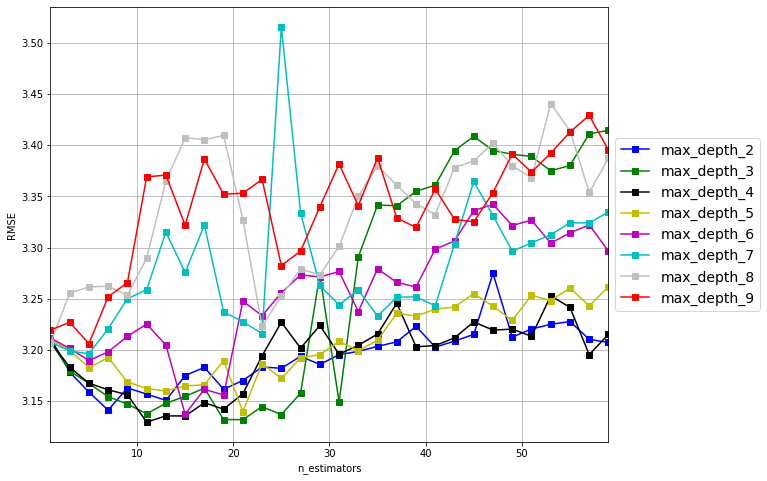

In [1282]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [1283]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 3.129
optimum params = 


(11, 4)

In [1284]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.915%
optimum params = 


(21, 3)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [1285]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 5.51


,learning_rate,min_child_weight,rmse,mape,mae
0,0.0001,5,3.221996,2.003725,2.769489
1,0.0001,6,3.221996,2.003724,2.769489
2,0.0001,7,3.221996,2.003724,2.769489
3,0.0001,8,3.221996,2.003724,2.769489
4,0.0001,9,3.221996,2.003724,2.769489
5,0.0001,10,3.221996,2.003724,2.769489
6,0.0001,11,3.222011,2.003735,2.769503
7,0.0001,12,3.222011,2.003735,2.769503
8,0.0001,13,3.222011,2.003735,2.769503
9,0.0001,14,3.222011,2.003734,2.769502


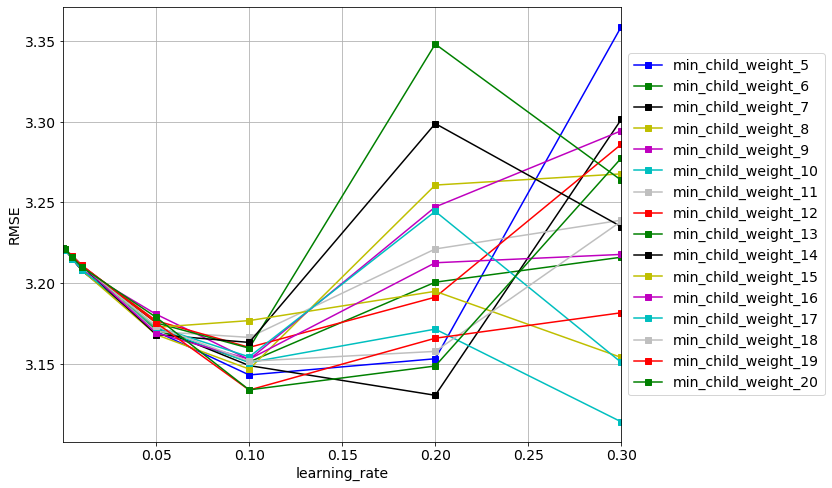

In [1286]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [1287]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 3.114
optimum params = 


(0.3, 10)

In [1288]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.904%
optimum params = 


(0.3, 10)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [1289]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 4.76


,subsample,gamma,rmse,mape,mae
0,0.1,0.0,3.252459,1.994671,2.755943
1,0.1,0.1,3.259487,1.997252,2.759377
2,0.1,0.2,3.168422,1.933309,2.674147
3,0.1,0.3,3.178234,1.939795,2.683359
4,0.1,0.4,3.184637,1.941528,2.685811
5,0.1,0.5,3.206699,1.956307,2.706518
6,0.1,0.6,3.249924,1.977357,2.735960
7,0.1,0.7,3.174185,1.939969,2.685124
8,0.1,0.8,3.155900,1.926378,2.666595
9,0.1,0.9,3.121467,1.912779,2.646564


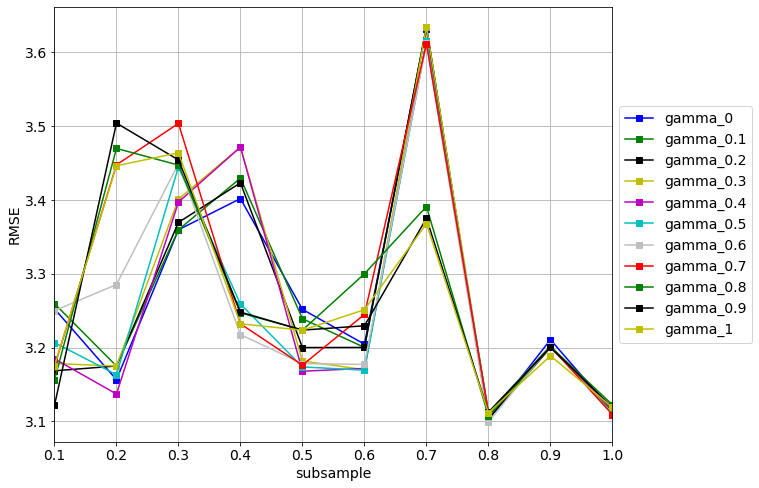

In [1290]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [1291]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 3.099
optimum params = 


(0.8, 0.6)

In [1292]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.902%
optimum params = 


(1.0, 0.7)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [1293]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 1.54


,colsample_bytree,colsample_bylevel,rmse,mape,mae
0,0.5,0.5,3.487712,2.140090,2.950906
1,0.5,0.6,3.519799,2.186978,3.022912
2,0.5,0.7,3.475755,2.134011,2.944451
3,0.5,0.8,3.300148,2.026787,2.798807
4,0.5,0.9,3.210901,1.979811,2.735147
5,0.5,1.0,3.130524,1.911550,2.640670
6,0.6,0.5,3.558256,2.195221,3.029926
7,0.6,0.6,3.416966,2.112799,2.917725
8,0.6,0.7,3.379573,2.084681,2.879110
9,0.6,0.8,3.344074,2.040834,2.817542


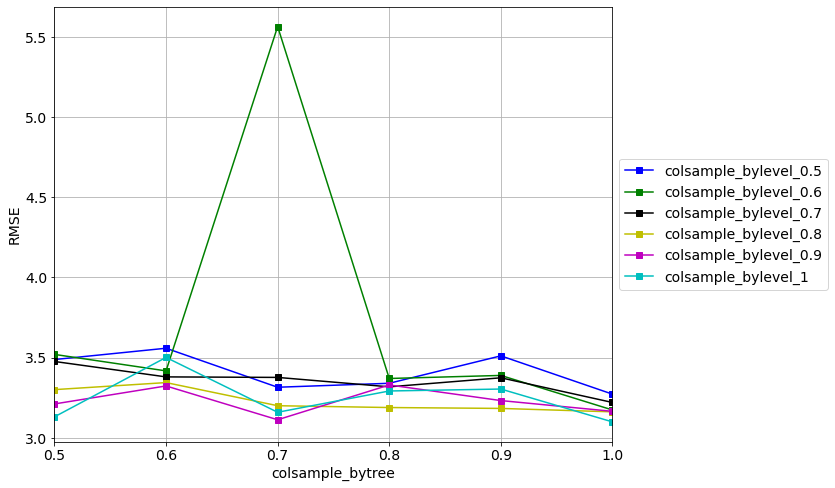

In [1294]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [1295]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 3.099
optimum params = 


(1.0, 1.0)

In [1296]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.902%
optimum params = 


(1.0, 1.0)

## Final model

In [1297]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N_opt,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 3.099
MAPE = 1.902%
MAE = 2.628


In [1298]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2017-10-16', '2018-11-12'])
fig.update_yaxes(range=[127, 157])
py.iplot(fig, filename='StockPricePrediction_v6d_xgboost_val_aft_tune_2018-11-01')

In [1299]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N_opt,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 2.465
MAPE = 1.377%
MAE = 1.903


In [1300]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [1301]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('month', 0.0),
 ('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('is_year_start', 0.0),
 ('dayofyear', 0.029689673),
 ('week', 0.035687167),
 ('adj_close_scaled_lag_2', 0.035818253),
 ('adj_close_scaled_lag_9', 0.037109658),
 ('adj_close_scaled_lag_4', 0.03744388),
 ('dayofweek', 0.04282764),
 ('adj_close_scaled_lag_5', 0.04708028),
 ('adj_close_scaled_lag_10', 0.047813736),
 ('day', 0.048916172),
 ('adj_close_scaled_lag_8', 0.049798343),
 ('year', 0.05020628),
 ('adj_close_scaled_lag_6', 0.05162626),
 ('adj_close_scaled_lag_3', 0.05664032),
 ('adj_close_scaled_lag_7', 0.06547863),
 ('adj_close_scaled_lag_1', 0.36386368)]

In [1317]:
# Plot the importance scores as a bar chart
fig = go.Figure(go.Bar(
            x=[item[1] for item in imp[-10:]],
            y=[item[0] for item in imp[-10:]],
            orientation='h'))
py.iplot(fig, filename='StockPricePrediction_v6d_xgboost_imp_scores')

## Tuned params

In [1303]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,n_estimators,100.000,11.000
1,max_depth,3.000,4.000
2,learning_rate,0.100,0.300
3,min_child_weight,1.000,10.000
4,subsample,1.000,0.800
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.600
8,val_rmse,3.465,3.099
9,val_mape,2.087,1.902


In [1304]:
# Put tuned_params into pickle
pickle.dump(tuned_params, open("./out/v6d_tuned_params_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [1305]:
# pickle.load(open("./out/v6d_tuned_params_" + "2017-03-06" + ".pickle", "rb"))

In [1306]:
toc1 = time.time()
print("Total minutes taken = {0:.2f}".format((toc1-tic1)/60.0))

Total minutes taken = 28.06


# Findings

In [1307]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'].strftime("%Y-%m-%d"), H))

Predicting on day 1470, date 2018-11-01, with forecast horizon H = 21


In [1308]:
rmse_bef_tuning, rmse_aft_tuning

(3.4652883574270277, 3.099049004330268)

In [1309]:
test_rmse_bef_tuning, test_rmse_aft_tuning

(2.508132066884724, 2.4646604434646626)

In [1310]:
# Put results into pickle
pickle.dump(rmse_bef_tuning, open("./out/v6d_val_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(rmse_aft_tuning, open("./out/v6d_val_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_bef_tuning, open("./out/v6d_test_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_bef_tuning, open("./out/v6d_test_mape_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_bef_tuning, open("./out/v6d_test_mae_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_aft_tuning, open("./out/v6d_test_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_aft_tuning, open("./out/v6d_test_mape_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_aft_tuning, open("./out/v6d_test_mae_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(est, open("./out/v6d_test_est_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [1311]:
# Consolidate results
# H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
# train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
# val_size = 252                 # Use 1 year of data as validation set
# N = 10                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
results = defaultdict(list)
ests = {} # the predictions
date_list = ['2017-01-03',
             '2017-03-06',
             '2017-05-04',
             '2017-07-05',
             '2017-09-01',
             '2017-11-01',
             '2018-01-03',
             '2018-03-06',
             '2018-05-04',
             '2018-07-05',
             '2018-09-04',
             '2018-11-01'
            ]
for date in date_list:
    results['date'].append(date)
    results['val_rmse_bef_tuning'].append(pickle.load(open( "./out/v6d_val_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['val_rmse_aft_tuning'].append(pickle.load(open( "./out/v6d_val_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_bef_tuning'].append(pickle.load(open( "./out/v6d_test_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_aft_tuning'].append(pickle.load(open( "./out/v6d_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mape_bef_tuning'].append(pickle.load(open( "./out/v6d_test_mape_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mape_aft_tuning'].append(pickle.load(open( "./out/v6d_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mae_bef_tuning'].append(pickle.load(open( "./out/v6d_test_mae_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mae_aft_tuning'].append(pickle.load(open( "./out/v6d_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    ests[date] = pickle.load(open( "./out/v6d_test_est_aft_tuning_" + date + ".pickle", "rb"))
    
results = pd.DataFrame(results)
results

,date,val_rmse_bef_tuning,val_rmse_aft_tuning,test_rmse_bef_tuning,test_rmse_aft_tuning,test_mape_bef_tuning,test_mape_aft_tuning,test_mae_bef_tuning,test_mae_aft_tuning
0,2017-01-03,2.093797,2.015173,3.312561,2.588796,2.848087,2.221614,3.219112,2.511283
1,2017-03-06,2.022238,1.725813,0.979531,1.302716,0.633085,0.952223,0.738801,1.112557
2,2017-05-04,1.802898,1.650805,0.953447,0.919764,0.579125,0.546620,0.692190,0.652835
3,2017-07-05,1.587039,1.443247,1.873800,1.759900,1.337507,1.264809,1.647921,1.557975
4,2017-09-01,1.437386,1.370932,1.972133,2.265510,1.350291,1.577865,1.695093,1.979998
5,2017-11-01,1.640414,1.534793,1.354321,1.385523,0.681379,0.714146,0.895074,0.937809
6,2018-01-03,1.554002,1.579436,3.303007,5.586847,2.086348,3.660253,2.951292,5.172152
7,2018-03-06,2.388266,2.144715,3.525196,3.164688,2.124344,2.072895,2.849931,2.801128
8,2018-05-04,3.051778,2.225725,4.910466,4.014922,3.425105,2.797213,4.739956,3.871148
9,2018-07-05,2.738347,2.437218,3.935224,3.633083,2.637730,2.425593,3.785378,3.481323


In [1312]:
tuned_params = pickle.load(open("./out/v6d_tuned_params_" + "2017-03-06" + ".pickle", "rb"))
tuned_params[tuned_params['param']=='n_estimators']['after_tuning'].values[0]

1.0

In [1313]:
# Generate a condensed dataframe of the above
results_short = defaultdict(list)
hyperparam_list = ['n_estimators', 
                   'max_depth', 
                   'learning_rate', 
                   'min_child_weight',
#                    'subsample',
#                    'colsample_bytree',
#                    'colsample_bylevel',
#                    'gamma'
                  ]

for date in date_list:
    results_short['date'].append(date)
    results_short['RMSE'].append(pickle.load(open( "./out/v6d_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAPE(%)'].append(pickle.load(open( "./out/v6d_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAE'].append(pickle.load(open( "./out/v6d_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    
    tuned_params = pickle.load(open("./out/v6d_tuned_params_" + date + ".pickle", "rb"))
    for hyperparam in hyperparam_list:
        results_short[hyperparam].append(tuned_params[tuned_params['param']==hyperparam]['after_tuning'].values[0])

    
results_short = pd.DataFrame(results_short)
results_short

,date,RMSE,MAPE(%),MAE,n_estimators,max_depth,learning_rate,min_child_weight
0,2017-01-03,2.588796,2.221614,2.511283,57.0,3.0,0.200,16.0
1,2017-03-06,1.302716,0.952223,1.112557,1.0,8.0,0.300,15.0
2,2017-05-04,0.919764,0.546620,0.652835,9.0,9.0,0.200,8.0
3,2017-07-05,1.759900,1.264809,1.557975,27.0,6.0,0.100,9.0
4,2017-09-01,2.265510,1.577865,1.979998,45.0,3.0,0.200,15.0
5,2017-11-01,1.385523,0.714146,0.937809,27.0,3.0,0.200,16.0
6,2018-01-03,5.586847,3.660253,5.172152,25.0,6.0,0.005,16.0
7,2018-03-06,3.164688,2.072895,2.801128,55.0,4.0,0.050,7.0
8,2018-05-04,4.014922,2.797213,3.871148,25.0,3.0,0.100,7.0
9,2018-07-05,3.633083,2.425593,3.481323,33.0,4.0,0.200,18.0


In [1314]:
results.mean()

val_rmse_bef_tuning     2.223159
val_rmse_aft_tuning     1.989954
test_rmse_bef_tuning    2.448512
test_rmse_aft_tuning    2.487090
test_mape_bef_tuning    1.634457
test_mape_aft_tuning    1.665891
test_mae_bef_tuning     2.158719
test_mae_aft_tuning     2.211944
dtype: float64

In [1315]:
# Plot all predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'],
                         mode='lines',
                         name='adj_close',
                         line=dict(color='blue')))

# Plot the predictions
n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['date'], 
                             y=ests[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2017-01-03', '2018-12-28'])
fig.update_yaxes(range=[110, 150])
py.iplot(fig, filename='StockPricePrediction_v6d_xgboost_predictions')

In [1316]:
# Plot scatter plot of actual values vs. predictions
fig = go.Figure()

n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['adj_close'], 
                             y=ests[key],
                             mode='markers',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.add_trace(go.Scatter(x=list(range(110, 155, 1)),
                         y=list(range(110, 155, 1)),
                         mode='lines',
                         name='actual values',
                         line=dict(color='blue')))

fig.update_layout(yaxis=dict(title='forecasts'),
                  xaxis=dict(title='adj_close'))
py.iplot(fig, filename='StockPricePrediction_v6d_xgboost_actuals_vs_predictions')

In [1319]:
# Compare results with benchmark
all_results = pd.DataFrame({'Method': ['Last value',  'XGBoost w/o date features', 'XGBoost w date features'],
                            'RMSE': [2.53, 2.55, 2.49],
                            'MAPE(%)': [1.69, 1.70, 1.67],
                            'MAE': [2.26, 2.27, 2.21]})
all_results

,Method,RMSE,MAPE(%),MAE
0,Last value,2.53,1.69,2.26
1,XGBoost w/o date features,2.55,1.70,2.27
2,XGBoost w date features,2.49,1.67,2.21
